In [1]:
import torchvision
print(torchvision.__version__)

0.21.0+cu124


In [3]:
# # Reload all modules every time before executing code
%load_ext autoreload
%autoreload 2  

In [2]:
from utils import Config
from data_loader import MultiOmicsDataset, create_dataloaders

### 7. Run pytest

In [4]:
%%bash
pytest -v


============================= test session starts ==============================
platform linux -- Python 3.11.11, pytest-8.3.5, pluggy-1.5.0 -- /home/CBBI/wangh5/miniforge3/envs/cs7643_a4_generative/bin/python3.11
cachedir: .pytest_cache
rootdir: /home/CBBI/wangh5/_PyCharm/proj_dl
configfile: pytest.ini
plugins: anyio-4.9.0
collecting ... collected 5 items

tests/test_02_model_components.py::test_vae_forward PASSED               [ 20%]
tests/test_02_model_components.py::test_mirna_vae_forward PASSED         [ 40%]
tests/test_02_model_components.py::test_mini_convnext PASSED             [ 60%]
tests/test_02_model_components.py::test_transformer_fusion PASSED        [ 80%]
tests/test_02_model_components.py::test_fusion_classifier PASSED         [100%]

============================== 5 passed in 0.28s ===============================


In [74]:
import json
from pathlib import Path
from sklearn.metrics import classification_report, accuracy_score
import torch

In [75]:
from utils import Config
from data_loader import MultiOmicsDataset, create_dataloaders
from models import MultiOmicsClassifier 
from trainers import BaseTrainer
from losses import MultiOmicsLoss

In [76]:
from trainers import CallbackTrainer
from callbacks import LossRecorderCallback, TSNERecorderCallback
from callbacks import AccuracyRecorderCallback
from callbacks import AttentionLoggerCallback
from utils import plot_tsne, plot_loss

def extract_latent(outputs):
    """Example: Extract latent representation from your specific model outputs"""
    return outputs['latent_rep']  # Replace with your actual latent key
    # Or if using concatenated features:
    # return torch.cat([outputs['mirna_latent'], outputs['rna_latent']], dim=1)

In [7]:
def get_training_parameters(trainer, include_model_info=False, include_optimizer_state=False):
    """Extracts all relevant training parameters in a structured dictionary.
    
    Args:
        trainer: BaseTrainer instance
        include_model_info: Whether to include model architecture details
        include_optimizer_state: Whether to include optimizer state details
        
    Returns:
        Dictionary containing all training parameters
    """
    params = {
        "training": {
            "device": str(trainer.device),
        },
        "loss": {
            "type": type(trainer.loss_fn).__name__,
            "beta": getattr(trainer.loss_fn, 'target_beta', None),
            "use_focal": getattr(trainer.loss_fn, 'use_focal', None),
            "focal_gamma": getattr(trainer.loss_fn, 'focal_gamma', None),
            "label_smoothing": getattr(trainer.loss_fn, 'label_smoothing', None),
            "kl_epsilon": getattr(trainer.loss_fn, 'kl_epsilon', None)
        },
        "optimizer": {
            "type": type(trainer.optimizer).__name__,
            "lr": trainer.optimizer.param_groups[0]['lr'],
            "betas": trainer.optimizer.param_groups[0].get('betas', None),
            "eps": trainer.optimizer.param_groups[0].get('eps', None),
            "weight_decay": trainer.optimizer.param_groups[0].get('weight_decay', None)
        }
    }
    
    if include_model_info:
        params["model"] = {
            "type": type(trainer.model).__name__,
            "total_parameters": sum(p.numel() for p in trainer.model.parameters()),
            "trainable_parameters": sum(p.numel() for p in trainer.model.parameters() 
                                      if p.requires_grad),
            "architecture": str(trainer.model)  # This shows the model structure
        }
    
    if include_optimizer_state:
        params["optimizer"]["state"] = {
            "momentum_buffer": any('momentum_buffer' in p for p in trainer.optimizer.state.values())
        }

    
    return params



# params = get_training_parameters(trainer)
# print(json.dumps(params, indent=4))


In [8]:
config = Config.from_yaml("configs/data_config.yaml")

dataset = MultiOmicsDataset(config)
dataloaders = create_dataloaders(dataset, config)



In [9]:

mirna_dim = 1046
rna_exp_dim = 13054
methy_shape = (50, 100)  # e.g., (50, 100)
latent_dim = 16
num_classes = 5

# Instantiate model
multiomics_model = MultiOmicsClassifier(
    mirna_dim=mirna_dim,
    rna_exp_dim=rna_exp_dim,
    methy_shape=methy_shape,
    latent_dim=latent_dim,
    num_classes=num_classes
)

In [10]:
trainer = BaseTrainer(
    model=multiomics_model,
    optimizer=torch.optim.Adam(multiomics_model.parameters(), lr=1e-3),
    loss_fn=MultiOmicsLoss(),
    device='cuda'
)

trainer.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=10)


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.88it/s]



📆 Epoch 1/10
🧮 Train Loss: 1.4950
🧪 Val Loss:   3.0679


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s, loss=1.4]


step    10 | loss: 1.2061 | ce: 1.0804 | kl: 16.5062 | beta: 0.0076


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.90it/s]



📆 Epoch 2/10
🧮 Train Loss: 1.3137
🧪 Val Loss:   1.8321


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.93it/s]



📆 Epoch 3/10
🧮 Train Loss: 1.1205
🧪 Val Loss:   1.4299


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.44it/s]



📆 Epoch 4/10
🧮 Train Loss: 1.0644
🧪 Val Loss:   1.3973


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s, loss=0.96]


step    30 | loss: 0.7854 | ce: 0.5821 | kl: 26.4387 | beta: 0.0077


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.12it/s]



📆 Epoch 5/10
🧮 Train Loss: 0.8696
🧪 Val Loss:   0.9774


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s, loss=0.89]


step    40 | loss: 0.8895 | ce: 0.7579 | kl: 17.0383 | beta: 0.0077


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.78it/s]



📆 Epoch 6/10
🧮 Train Loss: 0.6950
🧪 Val Loss:   1.3858


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.85it/s]



📆 Epoch 7/10
🧮 Train Loss: 0.5770
🧪 Val Loss:   2.0749


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s, loss=0.445]


step    50 | loss: 0.5342 | ce: 0.3529 | kl: 23.3601 | beta: 0.0078


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.34it/s]



📆 Epoch 8/10
🧮 Train Loss: 0.4662
🧪 Val Loss:   1.4967


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s, loss=0.219]


step    60 | loss: 0.3972 | ce: 0.2436 | kl: 19.6997 | beta: 0.0078


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.32it/s]



📆 Epoch 9/10
🧮 Train Loss: 0.4434
🧪 Val Loss:   0.9608


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.85it/s]


📆 Epoch 10/10
🧮 Train Loss: 0.4148
🧪 Val Loss:   1.0844


In [177]:
preds, targets = trainer.predict(dataloaders["test"])

# Compute accuracy
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

✅ Test Accuracy: 0.6818


In [178]:
preds, targets = trainer.predict(dataloaders["test"])

# Compute accuracy
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")




✅ Test Accuracy: 0.7576


In [180]:

print(classification_report(targets.numpy(), preds.numpy()))

params = get_training_parameters(trainer)
print(json.dumps(params, indent=4))


              precision    recall  f1-score   support

           0       0.87      0.69      0.77        29
           1       0.60      0.80      0.69        15
           2       0.89      0.89      0.89         9
           3       0.69      1.00      0.82         9
           4       1.00      0.25      0.40         4

    accuracy                           0.76        66
   macro avg       0.81      0.73      0.71        66
weighted avg       0.79      0.76      0.75        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "MultiOmicsLoss",
        "beta": 0.1,
        "use_focal": false,
        "focal_gamma": 2.0,
        "label_smoothing": 0.0,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "Adam",
        "lr": 0.001,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0
    }
}


In [181]:
trainer = BaseTrainer(
    model=multiomics_model,
    optimizer=torch.optim.Adam(multiomics_model.parameters(), lr=2e-5),
    loss_fn=MultiOmicsLoss(
                use_focal=False,
                # focal_gamma=2,        # Reduced from 0.5 for gentler hard example focus
                beta=1,               # Lower KL divergence weight
                # label_smoothing=0.1,    # Added smoothing
                class_weights=None  # torch.tensor([1.0, 1.5, 1.0, 1.0, 2.0], device="cuda")  # Targeted rebalancing
),
    device='cuda'
)

trainer.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=10)


Epoch 1/10


Training:   0%|                                                                                                                                                                                                                                        | 0/5 [00:00<?, ?it/s]/home/CBBI/wangh5/_PyCharm/proj_dl/losses/multi_omics.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'beta': torch.tensor(self.beta, device=self.current_step.device)
Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s, loss=1.38]


step     1 | loss: 1.3884 | ce: 0.2444 | kl: 15.0817 | beta: 0.0759
step     2 | loss: 1.3616 | ce: 0.2149 | kl: 15.1090 | beta: 0.0759
step     3 | loss: 1.2858 | ce: 0.2018 | kl: 14.2764 | beta: 0.0759
step     4 | loss: 1.5350 | ce: 0.3191 | kl: 16.0058 | beta: 0.0760
step     5 | loss: 1.3761 | ce: 0.2385 | kl: 14.9687 | beta: 0.0760
Train Loss: 1.3894


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.51it/s]


Val Loss:   1.7002

Epoch 2/10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s, loss=1.47]


step     8 | loss: 1.2782 | ce: 0.2502 | kl: 13.5076 | beta: 0.0761
step     9 | loss: 1.4166 | ce: 0.3285 | kl: 14.2913 | beta: 0.0761
step    10 | loss: 1.2747 | ce: 0.2449 | kl: 13.5191 | beta: 0.0762
step    11 | loss: 1.3343 | ce: 0.3174 | kl: 13.3435 | beta: 0.0762
step    12 | loss: 1.4679 | ce: 0.3445 | kl: 14.7338 | beta: 0.0762
Train Loss: 1.3543


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.93it/s]


Val Loss:   1.7782

Epoch 3/10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s, loss=1.15]


step    15 | loss: 1.3790 | ce: 0.3189 | kl: 13.8850 | beta: 0.0764
step    16 | loss: 1.3306 | ce: 0.3435 | kl: 12.9225 | beta: 0.0764
step    17 | loss: 1.3115 | ce: 0.2949 | kl: 13.3026 | beta: 0.0764
step    18 | loss: 1.2646 | ce: 0.2650 | kl: 13.0733 | beta: 0.0765
step    19 | loss: 1.1462 | ce: 0.2122 | kl: 12.2100 | beta: 0.0765
Train Loss: 1.2864


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.00it/s]


Val Loss:   1.6747

Epoch 4/10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s, loss=1.23]


step    22 | loss: 1.3173 | ce: 0.3238 | kl: 12.9706 | beta: 0.0766
step    23 | loss: 1.1850 | ce: 0.2628 | kl: 12.0338 | beta: 0.0766
step    24 | loss: 1.2360 | ce: 0.2450 | kl: 12.9256 | beta: 0.0767
step    25 | loss: 1.2104 | ce: 0.2663 | kl: 12.3084 | beta: 0.0767
step    26 | loss: 1.2265 | ce: 0.3386 | kl: 11.5700 | beta: 0.0767
Train Loss: 1.2351


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.12it/s]


Val Loss:   1.7607

Epoch 5/10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s, loss=1.22]


step    29 | loss: 1.1322 | ce: 0.2608 | kl: 11.3397 | beta: 0.0768
step    30 | loss: 1.1986 | ce: 0.3031 | kl: 11.6482 | beta: 0.0769
step    31 | loss: 1.1742 | ce: 0.3162 | kl: 11.1555 | beta: 0.0769
step    32 | loss: 1.1290 | ce: 0.2533 | kl: 11.3795 | beta: 0.0770
step    33 | loss: 1.2241 | ce: 0.3498 | kl: 11.3569 | beta: 0.0770
Train Loss: 1.1716


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.03it/s]


Val Loss:   0.9290

Epoch 6/10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s, loss=1.06]


step    36 | loss: 1.0760 | ce: 0.2084 | kl: 11.2546 | beta: 0.0771
step    37 | loss: 1.1733 | ce: 0.2932 | kl: 11.4102 | beta: 0.0771
step    38 | loss: 1.1178 | ce: 0.2951 | kl: 10.6608 | beta: 0.0772
step    39 | loss: 1.0720 | ce: 0.2618 | kl: 10.4946 | beta: 0.0772
step    40 | loss: 1.0627 | ce: 0.2721 | kl: 10.2364 | beta: 0.0772
Train Loss: 1.1003


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.75it/s]


Val Loss:   0.8711

Epoch 7/10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s, loss=1.06]


step    43 | loss: 1.0304 | ce: 0.2731 | kl: 9.7911 | beta: 0.0773
step    44 | loss: 1.1288 | ce: 0.3001 | kl: 10.7106 | beta: 0.0774
step    45 | loss: 1.0995 | ce: 0.3084 | kl: 10.2188 | beta: 0.0774
step    46 | loss: 1.0473 | ce: 0.3000 | kl: 9.6491 | beta: 0.0775
step    47 | loss: 1.0583 | ce: 0.2798 | kl: 10.0462 | beta: 0.0775
Train Loss: 1.0729


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.13it/s]


Val Loss:   1.4520

Epoch 8/10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s, loss=1.01]


step    50 | loss: 1.0614 | ce: 0.2865 | kl: 9.9861 | beta: 0.0776
step    51 | loss: 1.0340 | ce: 0.2858 | kl: 9.6378 | beta: 0.0776
step    52 | loss: 1.0012 | ce: 0.2828 | kl: 9.2501 | beta: 0.0777
step    53 | loss: 1.0272 | ce: 0.3462 | kl: 8.7645 | beta: 0.0777
step    54 | loss: 1.0143 | ce: 0.2856 | kl: 9.3744 | beta: 0.0777
Train Loss: 1.0276


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.07it/s]


Val Loss:   1.5720

Epoch 9/10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s, loss=1.06]


step    57 | loss: 0.8603 | ce: 0.2209 | kl: 8.2135 | beta: 0.0778
step    58 | loss: 0.9746 | ce: 0.2613 | kl: 9.1594 | beta: 0.0779
step    59 | loss: 1.0908 | ce: 0.4131 | kl: 8.6987 | beta: 0.0779
step    60 | loss: 0.9960 | ce: 0.3114 | kl: 8.7827 | beta: 0.0780
step    61 | loss: 1.0642 | ce: 0.3491 | kl: 9.1687 | beta: 0.0780
Train Loss: 0.9972


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.92it/s]


Val Loss:   1.4476

Epoch 10/10


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s, loss=0.965]


step    64 | loss: 0.9070 | ce: 0.2575 | kl: 8.3168 | beta: 0.0781
step    65 | loss: 1.0389 | ce: 0.3574 | kl: 8.7225 | beta: 0.0781
step    66 | loss: 0.9347 | ce: 0.3014 | kl: 8.1023 | beta: 0.0782
step    67 | loss: 1.0095 | ce: 0.3417 | kl: 8.5399 | beta: 0.0782
step    68 | loss: 0.9646 | ce: 0.3463 | kl: 7.9023 | beta: 0.0782
Train Loss: 0.9710


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.41it/s]

Val Loss:   1.4375


In [185]:
preds, targets = trainer.predict(dataloaders["test"])
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

print(classification_report(targets.numpy(), preds.numpy()))
params = get_training_parameters(trainer)

print(json.dumps(params, indent=4))



✅ Test Accuracy: 0.6818
              precision    recall  f1-score   support

           0       0.76      0.66      0.70        29
           1       0.42      0.53      0.47        15
           2       0.89      0.89      0.89         9
           3       0.75      1.00      0.86         9
           4       1.00      0.25      0.40         4

    accuracy                           0.68        66
   macro avg       0.76      0.67      0.66        66
weighted avg       0.71      0.68      0.68        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "MultiOmicsLoss",
        "beta": 1,
        "use_focal": false,
        "focal_gamma": 2.0,
        "label_smoothing": 0.0,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "Adam",
        "lr": 2e-05,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0
    }
}


In [227]:
loss_fn = MultiOmicsLoss(
    beta=0.25,               # Target KL weight
    # annealing_steps=5000,   # Total steps to anneal over
    # use_focal=True,
    # focal_gamma=1,
    # label_smoothing=0.1,
    # class_weights=None # or torch.tensor([...], device="cuda")
)

mirna_dim = 1046
rna_exp_dim = 13054
methy_shape = (50, 100)  # e.g., (50, 100)
latent_dim = 32
num_classes = 5

# Instantiate model
multiomics_model = MultiOmicsClassifier(
    mirna_dim=mirna_dim,
    rna_exp_dim=rna_exp_dim,
    methy_shape=methy_shape,
    latent_dim=latent_dim,
    num_classes=num_classes
)




loss_callback = LossRecorderCallback(save_path="logs/loss_history.json")
tsne_callback = TSNERecorderCallback(
    val_loader=dataloaders['val'],  # Your validation DataLoader
    device='cuda',
    save_path="tsne_results.pkl"  # Matches your plot_tsne() default
)

trainer_cb = CallbackTrainer(
    model=multiomics_model,
    optimizer=torch.optim.AdamW(multiomics_model.parameters(), lr=2e-4, weight_decay=0.01),
    loss_fn=loss_fn,
    device='cuda', 
    callbacks=[loss_callback, tsne_callback]
)

trainer_cb.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=50)


Epoch 1/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.78it/s, loss=1.71]


Train Loss: 1.8874


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s]

Val Loss:   20.0288



Epoch 2/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s, loss=1.46]


step    10 | loss: 1.5961 | ce: 1.3577 | kl: 12.5207 | beta: 0.0190
Train Loss: 1.6066


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.18it/s]

Val Loss:   2.5140



Epoch 3/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.75it/s, loss=1.54]


Train Loss: 1.5202


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.69it/s]

Val Loss:   1.7310



Epoch 4/50


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s, loss=1.7]


Train Loss: 1.4753


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.13it/s]

Val Loss:   1.4920



Epoch 5/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s, loss=1.61]


step    30 | loss: 1.3575 | ce: 1.1707 | kl: 9.7188 | beta: 0.0192
Train Loss: 1.4122


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.07it/s]

Val Loss:   1.4186



Epoch 6/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.77it/s, loss=1.47]


step    40 | loss: 1.4724 | ce: 1.3008 | kl: 8.8885 | beta: 0.0193
Train Loss: 1.3396


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.80it/s]

Val Loss:   1.5110



Epoch 7/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.39it/s, loss=1.16]


Train Loss: 1.2218


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.97it/s]

Val Loss:   1.6919



Epoch 8/50


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s, loss=1.3]


step    50 | loss: 1.2139 | ce: 1.0154 | kl: 10.2325 | beta: 0.0194
Train Loss: 1.2012


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.26it/s]

Val Loss:   1.5228



Epoch 9/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s, loss=1]


step    60 | loss: 1.1158 | ce: 0.8964 | kl: 11.2572 | beta: 0.0195
Train Loss: 1.0810


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.17it/s]

Val Loss:   1.1465



Epoch 10/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s, loss=1.53]


Train Loss: 1.1418


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.16it/s]

Val Loss:   1.1299



Epoch 11/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s, loss=1]


Train Loss: 0.9747


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.66it/s]

Val Loss:   1.0476



Epoch 12/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s, loss=1.75]


step    80 | loss: 1.0123 | ce: 0.7821 | kl: 11.7077 | beta: 0.0197
Train Loss: 1.0837


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.31it/s]

Val Loss:   1.0499



Epoch 13/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.62it/s, loss=0.991]


Train Loss: 0.9002


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.78it/s]

Val Loss:   1.2269



Epoch 14/50


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s, loss=1.2]


Train Loss: 0.9161


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.32it/s]

Val Loss:   1.2507



Epoch 15/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s, loss=1.08]


step   100 | loss: 0.7583 | ce: 0.5387 | kl: 11.0655 | beta: 0.0199
Train Loss: 0.8675


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.30it/s]

Val Loss:   1.1399



Epoch 16/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s, loss=0.856]


step   110 | loss: 0.8560 | ce: 0.6156 | kl: 12.0521 | beta: 0.0199
Train Loss: 0.7853


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.67it/s]

Val Loss:   1.3606



Epoch 17/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s, loss=0.539]


Train Loss: 0.7122


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.25it/s]

Val Loss:   1.0888



Epoch 18/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s, loss=0.798]


step   120 | loss: 0.7497 | ce: 0.5223 | kl: 11.3535 | beta: 0.0200
Train Loss: 0.7051


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.25it/s]

Val Loss:   0.8274



Epoch 19/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.21it/s, loss=0.715]


step   130 | loss: 0.7105 | ce: 0.4850 | kl: 11.2023 | beta: 0.0201
Train Loss: 0.6335


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.83it/s]

Val Loss:   0.9495



Epoch 20/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.12it/s, loss=0.599]


Train Loss: 0.6119


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.84it/s]

Val Loss:   0.8918



Epoch 21/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s, loss=0.389]


Train Loss: 0.5226


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.00it/s]

Val Loss:   0.8891



Epoch 22/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.55it/s, loss=0.592]

step   150 | loss: 0.6971 | ce: 0.4810 | kl: 10.6398 | beta: 0.0203


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s, loss=0.592]


Train Loss: 0.5766


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.62it/s]

Val Loss:   0.8445



Epoch 23/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.91it/s, loss=0.968]


Train Loss: 0.6578


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.38it/s]

Val Loss:   0.8226



Epoch 24/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s, loss=0.973]


Train Loss: 0.6281


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.06it/s]

Val Loss:   0.9253



Epoch 25/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s, loss=1.21]


step   170 | loss: 0.5591 | ce: 0.3405 | kl: 10.6610 | beta: 0.0205
Train Loss: 0.6666


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.11it/s]

Val Loss:   0.8989



Epoch 26/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s, loss=0.586]


step   180 | loss: 0.5859 | ce: 0.3069 | kl: 13.5479 | beta: 0.0206
Train Loss: 0.6279


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.26it/s]

Val Loss:   1.3114



Epoch 27/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s, loss=1.35]


Train Loss: 0.6931


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.03it/s]

Val Loss:   1.3168



Epoch 28/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s, loss=0.84]


step   190 | loss: 0.5904 | ce: 0.3266 | kl: 12.7515 | beta: 0.0207
Train Loss: 0.5906


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.90it/s]

Val Loss:   1.5438



Epoch 29/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s, loss=0.69]


step   200 | loss: 0.4586 | ce: 0.2400 | kl: 10.5169 | beta: 0.0208
Train Loss: 0.5298


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.13it/s]

Val Loss:   0.9931



Epoch 30/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s, loss=0.552]


Train Loss: 0.5031


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s]

Val Loss:   0.7330



Epoch 31/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s, loss=0.476]


Train Loss: 0.4904


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.24it/s]

Val Loss:   0.9220



Epoch 32/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.41it/s, loss=0.436]


step   220 | loss: 0.4707 | ce: 0.2390 | kl: 11.0482 | beta: 0.0210
Train Loss: 0.4367


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.28it/s]

Val Loss:   0.8579



Epoch 33/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.75it/s, loss=0.416]


Train Loss: 0.4557


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.97it/s]

Val Loss:   0.8482



Epoch 34/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s, loss=0.516]


Train Loss: 0.4865


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.62it/s]

Val Loss:   0.9070



Epoch 35/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s, loss=0.461]


step   240 | loss: 0.4735 | ce: 0.2403 | kl: 11.0125 | beta: 0.0212
Train Loss: 0.4499


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.40it/s]

Val Loss:   1.0327



Epoch 36/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s, loss=0.755]


step   250 | loss: 0.7546 | ce: 0.5524 | kl: 9.5064 | beta: 0.0213
Train Loss: 0.4879


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.00it/s]

Val Loss:   0.9214



Epoch 37/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.23it/s, loss=0.352]


Train Loss: 0.4049


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.89it/s]

Val Loss:   1.1451



Epoch 38/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s, loss=0.93]


step   260 | loss: 0.4672 | ce: 0.2335 | kl: 10.9427 | beta: 0.0214
Train Loss: 0.5172


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.13it/s]

Val Loss:   0.7479



Epoch 39/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s, loss=1.03]


step   270 | loss: 0.4369 | ce: 0.1795 | kl: 11.9934 | beta: 0.0215
Train Loss: 0.5304


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.31it/s]

Val Loss:   0.8859



Epoch 40/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s, loss=0.617]


Train Loss: 0.4946


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.46it/s]

Val Loss:   0.8056



Epoch 41/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.32it/s, loss=0.332]


Train Loss: 0.4044


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.42it/s]

Val Loss:   1.1030



Epoch 42/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s, loss=0.541]


step   290 | loss: 0.3890 | ce: 0.1627 | kl: 10.4477 | beta: 0.0217
Train Loss: 0.4608


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.41it/s]

Val Loss:   0.7932



Epoch 43/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s, loss=0.445]


Train Loss: 0.4725


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.36it/s]

Val Loss:   0.8136



Epoch 44/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s, loss=0.508]


Train Loss: 0.4648


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.62it/s]

Val Loss:   0.9852



Epoch 45/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s, loss=0.861]


step   310 | loss: 0.4512 | ce: 0.2220 | kl: 10.4862 | beta: 0.0219
Train Loss: 0.5112


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.69it/s]

Val Loss:   0.8418



Epoch 46/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s, loss=0.313]


step   320 | loss: 0.3130 | ce: 0.1026 | kl: 9.5813 | beta: 0.0220
Train Loss: 0.3754


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s]

Val Loss:   0.9213



Epoch 47/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s, loss=0.67]


Train Loss: 0.4571


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.05it/s]

Val Loss:   0.8449



Epoch 48/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s, loss=0.517]


step   330 | loss: 0.3513 | ce: 0.1137 | kl: 10.7726 | beta: 0.0221
Train Loss: 0.3936


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.44it/s]

Val Loss:   0.8452



Epoch 49/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s, loss=0.451]


step   340 | loss: 0.4009 | ce: 0.1547 | kl: 11.1128 | beta: 0.0222
Train Loss: 0.3926


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.59it/s]

Val Loss:   1.0302



Epoch 50/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.25it/s, loss=0.576]


Train Loss: 0.4058


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.36it/s]

Val Loss:   0.7286


In [116]:
preds, targets = trainer_cb.predict(dataloaders["test"])
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

print(classification_report(targets.numpy(), preds.numpy()))
params = get_training_parameters(trainer_cb)

print(json.dumps(params, indent=4))

✅ Test Accuracy: 0.6667
              precision    recall  f1-score   support

           0       0.66      0.79      0.72        29
           1       0.54      0.47      0.50        15
           2       0.78      0.78      0.78         9
           3       0.75      0.67      0.71         9
           4       1.00      0.25      0.40         4

    accuracy                           0.67        66
   macro avg       0.74      0.59      0.62        66
weighted avg       0.68      0.67      0.66        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "MultiOmicsLoss",
        "beta": 0.25,
        "use_focal": false,
        "focal_gamma": 2.0,
        "label_smoothing": 0.0,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "AdamW",
        "lr": 0.0002,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0.01
    }
}


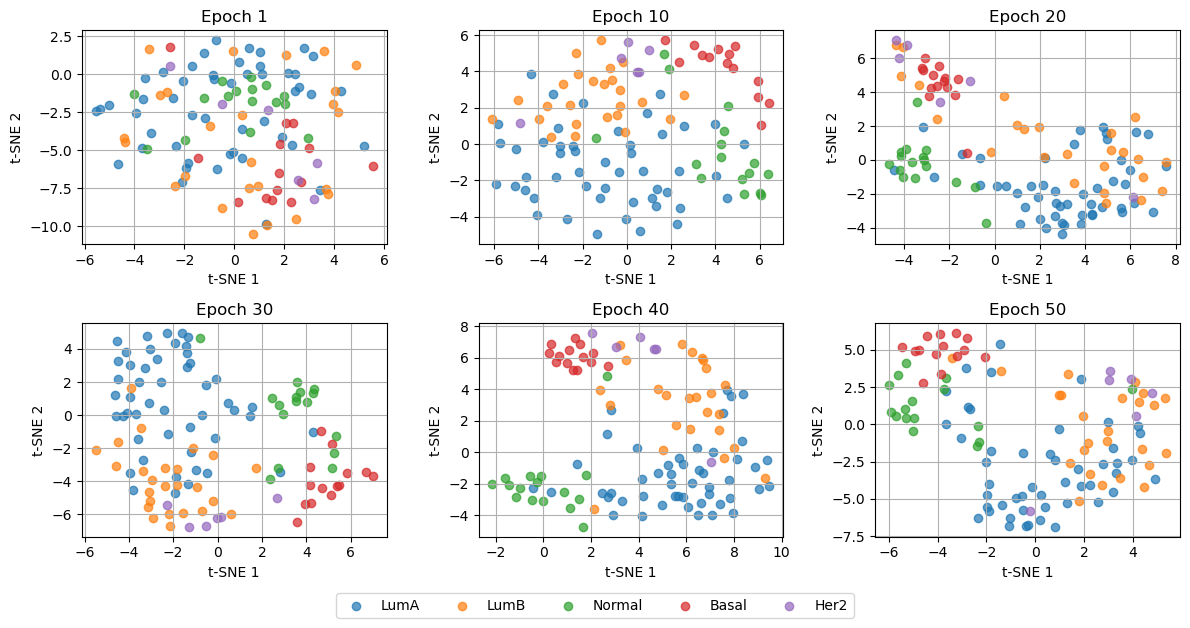

In [117]:

from utils import plot_tsne, plot_loss

plot_tsne(epochs=[1, 10, 20, 30, 40, 50], figsize=(4,3)) 

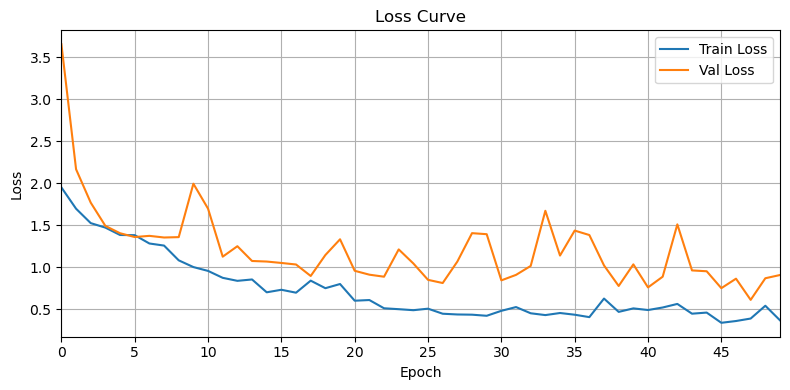

In [118]:
plot_loss(loss_path="logs/loss_history.json", figsize=(8, 4))

In [18]:
# trainer = BaseTrainer(
#     model=multiomics_model,
#     optimizer=torch.optim.Adam(multiomics_model.parameters(), lr=1e-4),
#     loss_fn=MultiOmicsLoss(),
#     device='cuda'
# )

# trainer.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=10)

loss_fn = MultiOmicsLoss(
    beta=0.1,               # Target KL weight
    annealing_steps=5000,   # Total steps to anneal over
    use_focal=True,
    focal_gamma=1,
    label_smoothing=0.1,
    class_weights=torch.tensor([1.0, 2.5, 1.0, 1.0, 1.5], device="cuda") # or torch.tensor([...], device="cuda")
)

mirna_dim = 1046
rna_exp_dim = 13054
methy_shape = (50, 100)  # e.g., (50, 100)
latent_dim = 32
num_classes = 5

# Instantiate model
multiomics_model = MultiOmicsClassifier(
    mirna_dim=mirna_dim,
    rna_exp_dim=rna_exp_dim,
    methy_shape=methy_shape,
    latent_dim=latent_dim,
    num_classes=num_classes
)




loss_callback = LossRecorderCallback(save_path="logs/loss_history.json")
tsne_callback = TSNERecorderCallback(
    val_loader=dataloaders['val'],  # Your validation DataLoader
    device='cuda',
    save_path="tsne_results.pkl"  # Matches your plot_tsne() default
)

trainer_cb = CallbackTrainer(
    model=multiomics_model,
    optimizer=torch.optim.Adam(multiomics_model.parameters(), lr=2e-4),
    loss_fn=loss_fn,
    device='cuda', 
    callbacks=[loss_callback, tsne_callback]
)

trainer_cb.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=50)

/home/CBBI/wangh5/_PyCharm/proj_dl/losses/focal.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('weight', torch.tensor(weight) if weight is not None else None)



Epoch 1/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s, loss=2.07]


Train Loss: 1.9079


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.19it/s]

Val Loss:   2.9910



Epoch 2/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s, loss=1.77]


step    10 | loss: 1.7042 | ce: 1.5532 | kl: 19.7359 | beta: 0.0076
Train Loss: 1.6803


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.84it/s]

Val Loss:   2.0878



Epoch 3/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s, loss=1.68]


Train Loss: 1.5518


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.29it/s]

Val Loss:   1.5809



Epoch 4/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s, loss=1.26]


Train Loss: 1.3826


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.01it/s]

Val Loss:   1.5596



Epoch 5/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.64it/s, loss=1.33]


step    30 | loss: 1.2200 | ce: 1.0819 | kl: 17.7204 | beta: 0.0078
Train Loss: 1.2894


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.34it/s]

Val Loss:   1.2939



Epoch 6/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s, loss=1.44]


step    40 | loss: 1.4382 | ce: 1.2639 | kl: 22.1724 | beta: 0.0079
Train Loss: 1.2120


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.12it/s]

Val Loss:   1.3153



Epoch 7/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s, loss=0.875]


Train Loss: 1.0391


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.07it/s]

Val Loss:   1.9880



Epoch 8/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s, loss=0.888]


step    50 | loss: 0.9839 | ce: 0.8281 | kl: 19.6223 | beta: 0.0079
Train Loss: 1.0064


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.80it/s]

Val Loss:   1.8812



Epoch 9/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s, loss=0.646]


step    60 | loss: 0.8221 | ce: 0.6588 | kl: 20.3879 | beta: 0.0080
Train Loss: 0.8594


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.95it/s]

Val Loss:   1.5034



Epoch 10/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s, loss=0.921]


Train Loss: 0.8874


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.15it/s]

Val Loss:   1.3330



Epoch 11/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s, loss=0.786]


Train Loss: 0.8232


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.74it/s]

Val Loss:   1.0706



Epoch 12/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s, loss=0.759]


step    80 | loss: 0.7325 | ce: 0.5672 | kl: 20.2624 | beta: 0.0082
Train Loss: 0.7462


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.70it/s]

Val Loss:   1.4363



Epoch 13/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s, loss=0.578]


Train Loss: 0.7238


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.69it/s]

Val Loss:   1.1008



Epoch 14/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s, loss=0.693]


Train Loss: 0.6835


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.75it/s]

Val Loss:   0.9348



Epoch 15/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s, loss=0.588]


step   100 | loss: 0.7136 | ce: 0.5536 | kl: 19.2568 | beta: 0.0083
Train Loss: 0.6378


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.09it/s]

Val Loss:   1.4742



Epoch 16/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.15it/s, loss=0.51]


step   110 | loss: 0.5104 | ce: 0.3855 | kl: 14.8937 | beta: 0.0084
Train Loss: 0.5861


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.27it/s]

Val Loss:   1.1143



Epoch 17/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s, loss=0.818]


Train Loss: 0.6114


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.16it/s]

Val Loss:   1.0594



Epoch 18/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s, loss=0.844]


step   120 | loss: 0.6038 | ce: 0.4550 | kl: 17.5835 | beta: 0.0085
Train Loss: 0.6779


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.30it/s]

Val Loss:   1.4426



Epoch 19/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s, loss=0.563]


step   130 | loss: 0.6482 | ce: 0.4632 | kl: 21.6663 | beta: 0.0085
Train Loss: 0.6015


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.75it/s]

Val Loss:   2.5375



Epoch 20/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s, loss=0.738]


Train Loss: 0.6488


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.41it/s]

Val Loss:   1.3449



Epoch 21/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s, loss=0.591]


Train Loss: 0.5687


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s]

Val Loss:   1.2090



Epoch 22/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s, loss=0.557]


step   150 | loss: 0.5177 | ce: 0.3550 | kl: 18.6967 | beta: 0.0087
Train Loss: 0.5281


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.67it/s]

Val Loss:   1.2750



Epoch 23/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s, loss=0.582]


Train Loss: 0.5213


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.13it/s]

Val Loss:   1.1202



Epoch 24/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.02it/s, loss=0.465]


Train Loss: 0.4742


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.37it/s]

Val Loss:   1.1195



Epoch 25/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s, loss=0.658]


step   170 | loss: 0.6666 | ce: 0.5062 | kl: 18.1089 | beta: 0.0089
Train Loss: 0.5522


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.16it/s]

Val Loss:   1.0517



Epoch 26/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s, loss=0.898]


step   180 | loss: 0.8980 | ce: 0.8120 | kl: 9.6206 | beta: 0.0089
Train Loss: 0.5512


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.66it/s]

Val Loss:   1.4947



Epoch 27/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s, loss=0.401]


Train Loss: 0.4853


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.23it/s]

Val Loss:   1.3609



Epoch 28/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s, loss=0.46]


step   190 | loss: 0.4633 | ce: 0.2930 | kl: 18.8779 | beta: 0.0090
Train Loss: 0.5057


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.75it/s]

Val Loss:   1.3667



Epoch 29/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s, loss=0.542]


step   200 | loss: 0.4944 | ce: 0.3293 | kl: 18.1341 | beta: 0.0091
Train Loss: 0.4979


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.03it/s]

Val Loss:   1.0658



Epoch 30/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s, loss=0.438]


Train Loss: 0.4613


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.90it/s]

Val Loss:   0.8508



Epoch 31/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s, loss=0.523]


Train Loss: 0.4520


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.78it/s]

Val Loss:   0.9592



Epoch 32/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s, loss=0.497]


step   220 | loss: 0.4451 | ce: 0.3088 | kl: 14.7017 | beta: 0.0093
Train Loss: 0.4559


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.79it/s]

Val Loss:   1.0136



Epoch 33/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s, loss=0.416]


Train Loss: 0.4641


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.92it/s]

Val Loss:   0.9714



Epoch 34/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s, loss=0.404]


Train Loss: 0.4415


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.72it/s]

Val Loss:   1.0608



Epoch 35/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s, loss=0.437]


step   240 | loss: 0.4045 | ce: 0.2698 | kl: 14.2648 | beta: 0.0094
Train Loss: 0.4405


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.53it/s]

Val Loss:   0.9510



Epoch 36/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s, loss=1.18]


step   250 | loss: 1.1825 | ce: 1.0999 | kl: 8.6713 | beta: 0.0095
Train Loss: 0.5707


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.13it/s]

Val Loss:   1.1005



Epoch 37/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s, loss=0.457]


Train Loss: 0.4888


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.13it/s]

Val Loss:   1.2215



Epoch 38/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s, loss=0.559]


step   260 | loss: 0.5133 | ce: 0.3520 | kl: 16.7737 | beta: 0.0096
Train Loss: 0.4985


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.69it/s]

Val Loss:   1.2807



Epoch 39/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s, loss=0.448]


step   270 | loss: 0.5238 | ce: 0.3711 | kl: 15.7436 | beta: 0.0097
Train Loss: 0.4685


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.32it/s]

Val Loss:   1.7891



Epoch 40/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s, loss=0.807]


Train Loss: 0.5198


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.88it/s]

Val Loss:   1.5396



Epoch 41/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s, loss=0.53]


Train Loss: 0.4793


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.73it/s]

Val Loss:   1.1370



Epoch 42/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s, loss=0.681]


step   290 | loss: 0.4400 | ce: 0.2891 | kl: 15.2757 | beta: 0.0099
Train Loss: 0.4938


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.67it/s]

Val Loss:   1.2380



Epoch 43/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s, loss=0.985]


Train Loss: 0.5962


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.04it/s]

Val Loss:   1.1264



Epoch 44/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s, loss=0.886]


Train Loss: 0.5587


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.50it/s]

Val Loss:   1.2884



Epoch 45/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s, loss=0.49]


step   310 | loss: 0.5038 | ce: 0.3143 | kl: 18.8424 | beta: 0.0101
Train Loss: 0.5378


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.46it/s]

Val Loss:   1.5708



Epoch 46/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s, loss=0.54]


step   320 | loss: 0.5400 | ce: 0.3205 | kl: 21.6284 | beta: 0.0101
Train Loss: 0.5990


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.66it/s]

Val Loss:   1.0444



Epoch 47/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s, loss=1.41]


Train Loss: 0.6926


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.57it/s]

Val Loss:   0.9554



Epoch 48/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s, loss=0.429]


step   330 | loss: 0.4698 | ce: 0.2607 | kl: 20.4237 | beta: 0.0102
Train Loss: 0.4841


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.73it/s]

Val Loss:   1.6637



Epoch 49/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s, loss=0.603]


step   340 | loss: 0.5201 | ce: 0.3355 | kl: 17.8658 | beta: 0.0103
Train Loss: 0.5499


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.15it/s]

Val Loss:   1.4050



Epoch 50/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s, loss=1.75]


Train Loss: 0.7243


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.60it/s]

Val Loss:   1.1634


In [51]:
preds, targets = trainer_cb.predict(dataloaders["test"])
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

print(classification_report(targets.numpy(), preds.numpy()))
params = get_training_parameters(trainer_cb)

print(json.dumps(params, indent=4))

✅ Test Accuracy: 0.7273
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        29
           1       0.57      0.53      0.55        15
           2       0.90      1.00      0.95         9
           3       0.62      0.89      0.73         9
           4       1.00      0.50      0.67         4

    accuracy                           0.73        66
   macro avg       0.77      0.73      0.73        66
weighted avg       0.74      0.73      0.72        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "MultiOmicsLoss",
        "beta": 0.1,
        "use_focal": true,
        "focal_gamma": 1.5,
        "label_smoothing": 0,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "Adam",
        "lr": 0.0002,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0
    }
}


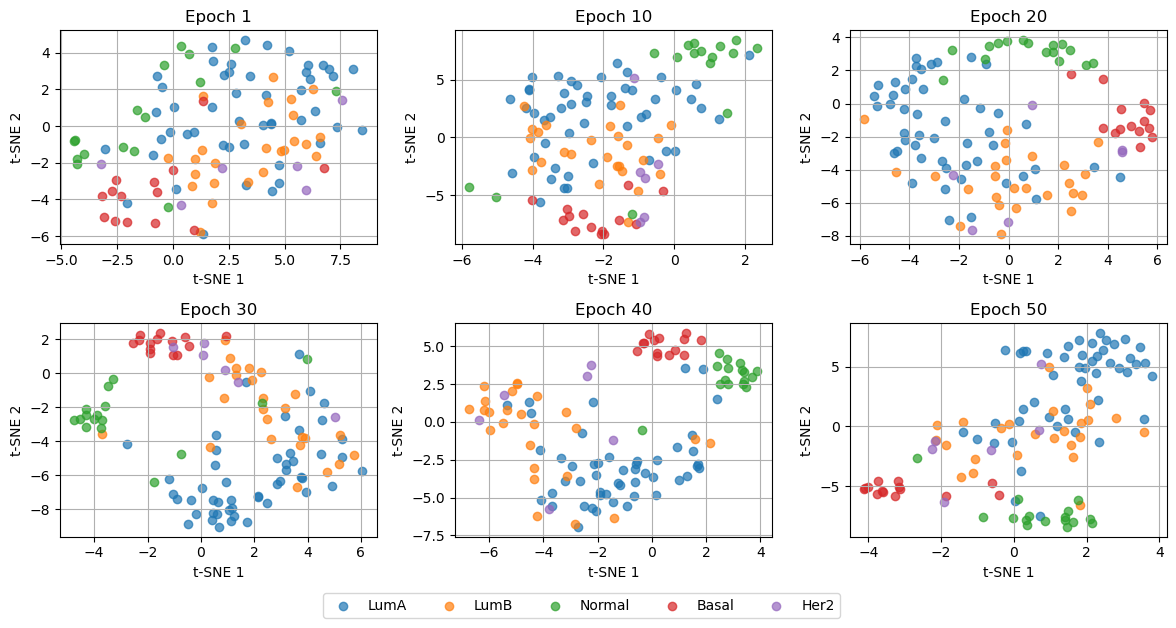

In [53]:

from utils import plot_tsne, plot_loss

plot_tsne(epochs=[1, 10, 20, 30, 40, 50], figsize=(4,3)) 


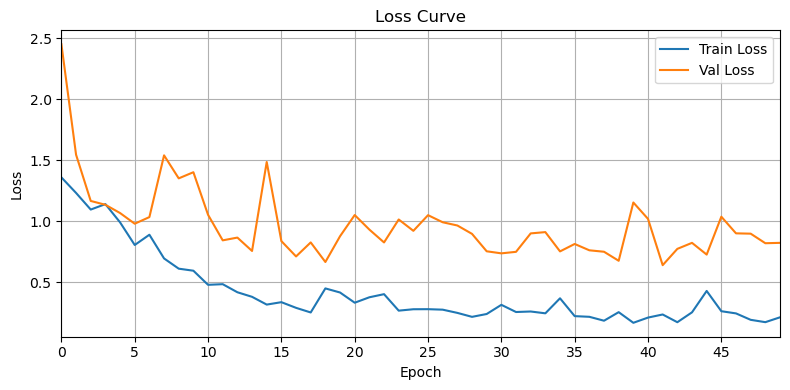

In [54]:
plot_loss(loss_path="logs/loss_history.json", figsize=(8, 4))

In [153]:
for name, param in multiomics_model.named_parameters():
    print(name, param.grad is not None)

methy_encoder.stem.0.weight True
methy_encoder.stem.0.bias True
methy_encoder.stem.1.norm.weight True
methy_encoder.stem.1.norm.bias True
methy_encoder.blocks.0.dwconv.weight True
methy_encoder.blocks.0.dwconv.bias True
methy_encoder.blocks.0.norm.weight True
methy_encoder.blocks.0.norm.bias True
methy_encoder.blocks.0.pwconv1.weight True
methy_encoder.blocks.0.pwconv1.bias True
methy_encoder.blocks.0.pwconv2.weight True
methy_encoder.blocks.0.pwconv2.bias True
methy_encoder.blocks.1.dwconv.weight True
methy_encoder.blocks.1.dwconv.bias True
methy_encoder.blocks.1.norm.weight True
methy_encoder.blocks.1.norm.bias True
methy_encoder.blocks.1.pwconv1.weight True
methy_encoder.blocks.1.pwconv1.bias True
methy_encoder.blocks.1.pwconv2.weight True
methy_encoder.blocks.1.pwconv2.bias True
methy_encoder.head.2.weight True
methy_encoder.head.2.bias True
methy_encoder.head.3.weight True
methy_encoder.head.3.bias True
mirna_vae.encoder.0.weight True
mirna_vae.encoder.0.bias True
mirna_vae.encode

In [202]:
loss_fn = MultiOmicsLoss(
    beta=0.25,               # Target KL weight
    # annealing_steps=5000,   # Total steps to anneal over
    use_focal=True,
    focal_gamma=2.5,
    label_smoothing=0,
    class_weights=torch.tensor([1.0, 1.0, 1.0, 1.5, 2.5], device="cuda") # or torch.tensor([...], device="cuda")
)

mirna_dim = 1046
rna_exp_dim = 13054
methy_shape = (50, 100)  # e.g., (50, 100)
latent_dim = 32
num_classes = 5

# Instantiate model
multiomics_model = MultiOmicsClassifier(
    mirna_dim=mirna_dim,
    rna_exp_dim=rna_exp_dim,
    methy_shape=methy_shape,
    latent_dim=latent_dim,
    num_classes=num_classes
)




loss_callback = LossRecorderCallback(save_path="logs/loss_history.json")
acc_callback = AccuracyRecorderCallback(save_path=Path("logs/accuracy_history.json"))

tsne_callback = TSNERecorderCallback(
    val_loader=dataloaders['val'],  # Your validation DataLoader
    device='cuda',
    save_path="tsne_results.pkl"  # Matches your plot_tsne() default
)



trainer_cb = CallbackTrainer(
    model=multiomics_model,
    optimizer=torch.optim.AdamW(multiomics_model.parameters(), lr=2e-4, weight_decay=0.0001),
    loss_fn=loss_fn,
    device='cuda', 
    callbacks=[loss_callback, tsne_callback, acc_callback],
    seed=42
)

trainer_cb.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=50)


Epoch 1/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s, loss=1.36]


Train Loss: 1.5255


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.52it/s]

Val Loss:   4.5514


✅ Val Accuracy: 0.4182

Epoch 2/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s, loss=0.987]


step    10 | loss: 1.3234 | ce: 1.0471 | kl: 14.5090 | beta: 0.0190
Train Loss: 1.2397


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.48it/s]

Val Loss:   2.1449


✅ Val Accuracy: 0.4545

Epoch 3/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.95it/s, loss=1.27]


Train Loss: 1.1530


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.51it/s]

Val Loss:   1.6341


✅ Val Accuracy: 0.5091

Epoch 4/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s, loss=1.46]


Train Loss: 1.0927


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.54it/s]

Val Loss:   1.1704


✅ Val Accuracy: 0.6182

Epoch 5/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s, loss=0.805]


step    30 | loss: 0.8509 | ce: 0.6199 | kl: 12.0219 | beta: 0.0192
Train Loss: 0.8887


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.34it/s]

Val Loss:   1.0907


✅ Val Accuracy: 0.7273

Epoch 6/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s, loss=0.669]


step    40 | loss: 0.6689 | ce: 0.4812 | kl: 9.7223 | beta: 0.0193
Train Loss: 0.8294


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.44it/s]

Val Loss:   1.0905


✅ Val Accuracy: 0.6909

Epoch 7/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s, loss=0.519]


Train Loss: 0.7203


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.11it/s]

Val Loss:   0.9192


✅ Val Accuracy: 0.7273

Epoch 8/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s, loss=0.86]


step    50 | loss: 0.6147 | ce: 0.3959 | kl: 11.2781 | beta: 0.0194
Train Loss: 0.6946


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.46it/s]

Val Loss:   0.7926


✅ Val Accuracy: 0.7455

Epoch 9/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s, loss=0.598]


step    60 | loss: 0.5570 | ce: 0.3467 | kl: 10.7904 | beta: 0.0195
Train Loss: 0.6274


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.57it/s]

Val Loss:   0.8974


✅ Val Accuracy: 0.5818

Epoch 10/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s, loss=0.557]


Train Loss: 0.5865


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.40it/s]

Val Loss:   1.3360


✅ Val Accuracy: 0.5091

Epoch 11/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s, loss=0.395]


Train Loss: 0.5304


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.83it/s]

Val Loss:   0.8121


✅ Val Accuracy: 0.6455

Epoch 12/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s, loss=0.389]


step    80 | loss: 0.4579 | ce: 0.2236 | kl: 11.9152 | beta: 0.0197
Train Loss: 0.4746


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.30it/s]

Val Loss:   0.9429


✅ Val Accuracy: 0.5273

Epoch 13/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.05it/s, loss=0.948]


Train Loss: 0.5741


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.52it/s]

Val Loss:   0.7111


✅ Val Accuracy: 0.6636

Epoch 14/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s, loss=0.787]


Train Loss: 0.5449


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.47it/s]

Val Loss:   0.7082


✅ Val Accuracy: 0.6545

Epoch 15/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s, loss=0.442]


step   100 | loss: 0.5217 | ce: 0.2617 | kl: 13.0978 | beta: 0.0199
Train Loss: 0.4717


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.51it/s]

Val Loss:   0.7236


✅ Val Accuracy: 0.7273

Epoch 16/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s, loss=0.312]


step   110 | loss: 0.3125 | ce: 0.0708 | kl: 12.1188 | beta: 0.0199
Train Loss: 0.4356


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.44it/s]

Val Loss:   0.6055


✅ Val Accuracy: 0.7909

Epoch 17/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s, loss=0.507]


Train Loss: 0.4077


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.41it/s]

Val Loss:   0.6744


✅ Val Accuracy: 0.6727

Epoch 18/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.76it/s, loss=0.348]


step   120 | loss: 0.4850 | ce: 0.2801 | kl: 10.2302 | beta: 0.0200
Train Loss: 0.3907


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.45it/s]

Val Loss:   0.6084


✅ Val Accuracy: 0.6818

Epoch 19/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.92it/s, loss=0.565]


step   130 | loss: 0.3872 | ce: 0.1950 | kl: 9.5517 | beta: 0.0201
Train Loss: 0.3962


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.20it/s]

Val Loss:   0.5589


✅ Val Accuracy: 0.8545

Epoch 20/50


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s, loss=0.4]


Train Loss: 0.3641


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.46it/s]

Val Loss:   0.4564


✅ Val Accuracy: 0.7091

Epoch 21/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.20it/s, loss=0.531]


Train Loss: 0.3683


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.10it/s]

Val Loss:   0.5688


✅ Val Accuracy: 0.7818

Epoch 22/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s, loss=0.48]


step   150 | loss: 0.2895 | ce: 0.1184 | kl: 8.4269 | beta: 0.0203
Train Loss: 0.3519


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.24it/s]

Val Loss:   0.4810


✅ Val Accuracy: 0.7273

Epoch 23/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s, loss=0.38]


Train Loss: 0.3543


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.39it/s]

Val Loss:   0.8332


✅ Val Accuracy: 0.6909

Epoch 24/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s, loss=0.41]


Train Loss: 0.3377


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.91it/s]

Val Loss:   0.6946


✅ Val Accuracy: 0.6818

Epoch 25/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.70it/s, loss=0.296]


step   170 | loss: 0.3279 | ce: 0.1390 | kl: 9.2136 | beta: 0.0205
Train Loss: 0.3307


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.53it/s]

Val Loss:   0.7244


✅ Val Accuracy: 0.7545

Epoch 26/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s, loss=0.218]


step   180 | loss: 0.2185 | ce: 0.0832 | kl: 6.5707 | beta: 0.0206
Train Loss: 0.2699


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.28it/s]

Val Loss:   0.8422


✅ Val Accuracy: 0.7818

Epoch 27/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s, loss=0.31]


Train Loss: 0.3160


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.32it/s]

Val Loss:   0.7959


✅ Val Accuracy: 0.6364

Epoch 28/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.64it/s, loss=0.453]


step   190 | loss: 0.3382 | ce: 0.1509 | kl: 9.0494 | beta: 0.0207
Train Loss: 0.3438


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.44it/s]

Val Loss:   0.7322


✅ Val Accuracy: 0.6909

Epoch 29/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.92it/s, loss=0.748]


step   200 | loss: 0.3994 | ce: 0.1758 | kl: 10.7561 | beta: 0.0208
Train Loss: 0.4142


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.16it/s]

Val Loss:   0.5161


✅ Val Accuracy: 0.7000

Epoch 30/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s, loss=0.444]


Train Loss: 0.3407


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.56it/s]

Val Loss:   0.6988


✅ Val Accuracy: 0.6273

Epoch 31/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s, loss=0.467]


Train Loss: 0.3260


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.57it/s]

Val Loss:   0.5603


✅ Val Accuracy: 0.6273

Epoch 32/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.95it/s, loss=0.265]


step   220 | loss: 0.3311 | ce: 0.1275 | kl: 9.7032 | beta: 0.0210
Train Loss: 0.2893


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.68it/s]

Val Loss:   0.6042


✅ Val Accuracy: 0.6636

Epoch 33/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s, loss=0.327]


Train Loss: 0.3292


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.34it/s]

Val Loss:   0.7676


✅ Val Accuracy: 0.5909

Epoch 34/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s, loss=0.244]


Train Loss: 0.2772


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.19it/s]

Val Loss:   0.6227


✅ Val Accuracy: 0.7727

Epoch 35/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s, loss=0.279]


step   240 | loss: 0.2338 | ce: 0.0506 | kl: 8.6524 | beta: 0.0212
Train Loss: 0.2719


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.27it/s]

Val Loss:   0.7451


✅ Val Accuracy: 0.7182

Epoch 36/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s, loss=0.213]


step   250 | loss: 0.2128 | ce: 0.0730 | kl: 6.5765 | beta: 0.0213
Train Loss: 0.2497


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.61it/s]

Val Loss:   0.7784


✅ Val Accuracy: 0.7909

Epoch 37/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.70it/s, loss=0.242]


Train Loss: 0.2459


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.89it/s]

Val Loss:   0.7290


✅ Val Accuracy: 0.7364

Epoch 38/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s, loss=0.263]


step   260 | loss: 0.2263 | ce: 0.0657 | kl: 7.5144 | beta: 0.0214
Train Loss: 0.2366


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.35it/s]

Val Loss:   0.5932


✅ Val Accuracy: 0.7364

Epoch 39/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s, loss=0.211]


step   270 | loss: 0.3392 | ce: 0.1990 | kl: 6.5357 | beta: 0.0215
Train Loss: 0.2491


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.32it/s]

Val Loss:   0.5570


✅ Val Accuracy: 0.7273

Epoch 40/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s, loss=0.336]


Train Loss: 0.2638


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.63it/s]

Val Loss:   0.5243


✅ Val Accuracy: 0.7091

Epoch 41/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s, loss=0.135]


Train Loss: 0.2051


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.42it/s]

Val Loss:   0.3570


✅ Val Accuracy: 0.7273

Epoch 42/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s, loss=0.203]


step   290 | loss: 0.2131 | ce: 0.0595 | kl: 7.0904 | beta: 0.0217
Train Loss: 0.2220


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.47it/s]

Val Loss:   0.5196


✅ Val Accuracy: 0.7273

Epoch 43/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.95it/s, loss=0.223]


Train Loss: 0.2339


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.30it/s]

Val Loss:   0.5221


✅ Val Accuracy: 0.6727

Epoch 44/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s, loss=0.184]


Train Loss: 0.2417


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.60it/s]

Val Loss:   0.6444


✅ Val Accuracy: 0.7000

Epoch 45/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s, loss=0.189]


step   310 | loss: 0.2610 | ce: 0.0685 | kl: 8.8079 | beta: 0.0219
Train Loss: 0.2266


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.88it/s]

Val Loss:   0.5983


✅ Val Accuracy: 0.7455

Epoch 46/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.46it/s, loss=0.304]


step   320 | loss: 0.3039 | ce: 0.1503 | kl: 6.9945 | beta: 0.0220
Train Loss: 0.2407


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.52it/s]

Val Loss:   0.5773


✅ Val Accuracy: 0.7364

Epoch 47/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s, loss=0.388]


Train Loss: 0.2457


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.11it/s]

Val Loss:   0.7068


✅ Val Accuracy: 0.6818

Epoch 48/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s, loss=0.725]


step   330 | loss: 0.2489 | ce: 0.0798 | kl: 7.6686 | beta: 0.0221
Train Loss: 0.3513


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.54it/s]

Val Loss:   1.1282


✅ Val Accuracy: 0.6182

Epoch 49/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s, loss=0.543]


step   340 | loss: 0.3457 | ce: 0.1451 | kl: 9.0545 | beta: 0.0222
Train Loss: 0.3464


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.66it/s]

Val Loss:   0.8238


✅ Val Accuracy: 0.7182

Epoch 50/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.70it/s, loss=0.193]


Train Loss: 0.2576


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.65it/s]

Val Loss:   0.6124


✅ Val Accuracy: 0.6000


In [205]:
from utils import set_seed
set_seed(42)
preds, targets = trainer_cb.predict(dataloaders["test"])
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

print(classification_report(targets.numpy(), preds.numpy()))
params = get_training_parameters(trainer_cb)

print(json.dumps(params, indent=4))

✅ Test Accuracy: 0.6818
              precision    recall  f1-score   support

           0       0.71      0.83      0.76        29
           1       0.50      0.20      0.29        15
           2       0.90      1.00      0.95         9
           3       0.73      0.89      0.80         9
           4       0.20      0.25      0.22         4

    accuracy                           0.68        66
   macro avg       0.61      0.63      0.60        66
weighted avg       0.66      0.68      0.65        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "MultiOmicsLoss",
        "beta": 0.25,
        "use_focal": true,
        "focal_gamma": 2.5,
        "label_smoothing": 0,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "AdamW",
        "lr": 0.0002,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0.0001
    }
}


In [193]:
import numpy as np
from sklearn.metrics import accuracy_score
from utils import set_seed
import torch

def evaluate_multiple_seeds(trainer, test_loader, seeds=100):
    accs = []

    for seed in np.random.randint(0, 10_000, size=seeds):
        set_seed(int(seed))  # Reset seed
        preds, targets = trainer.predict(test_loader)
        acc = accuracy_score(targets.numpy(), preds.numpy())
        accs.append(acc)

    accs = np.array(accs)
    print(f"\n✅ Avg Accuracy over {seeds} seeds: {accs.mean():.4f} ± {accs.std():.4f}")
    return accs
accs = evaluate_multiple_seeds(trainer_cb, dataloaders["test"], seeds=100)



✅ Avg Accuracy over 100 seeds: 0.6523 ± 0.0468


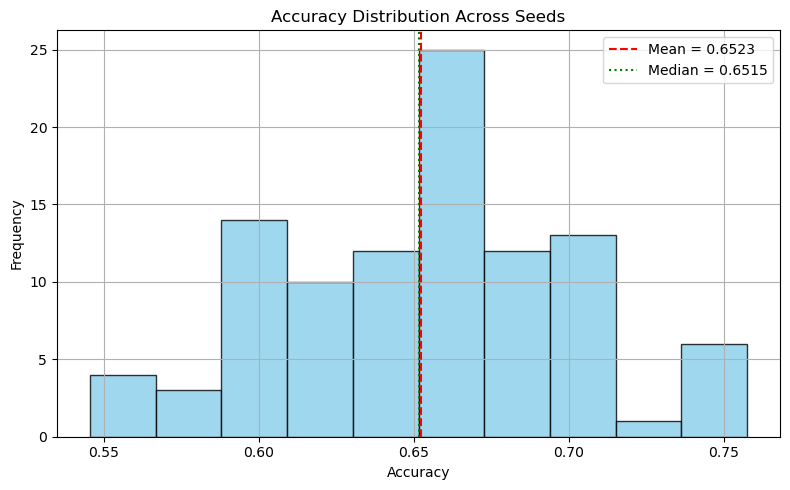

In [195]:
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracy_distribution(accs, bins=10, title="Accuracy Distribution Across Seeds"):
    plt.figure(figsize=(8, 5))
    plt.hist(accs, bins=bins, color="skyblue", edgecolor="black", alpha=0.8)
    plt.axvline(np.mean(accs), color='red', linestyle='--', label=f"Mean = {np.mean(accs):.4f}")
    plt.axvline(np.median(accs), color='green', linestyle=':', label=f"Median = {np.median(accs):.4f}")
    
    plt.title(title)
    plt.xlabel("Accuracy")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_accuracy_distribution(accs)

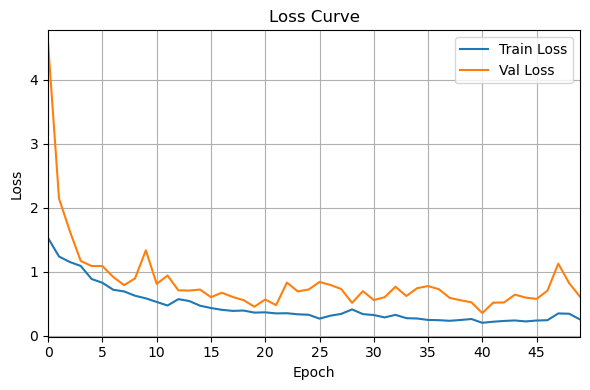

In [206]:
plot_loss(loss_path="logs/loss_history.json", figsize=(6, 4))

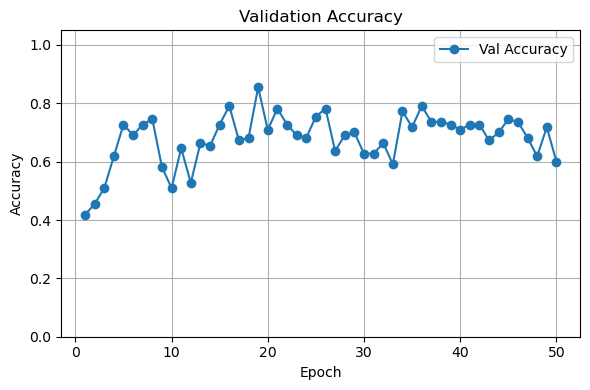

In [207]:
from utils import plot_accuracy
plot_accuracy("logs/accuracy_history.json", figsize=(6, 4))

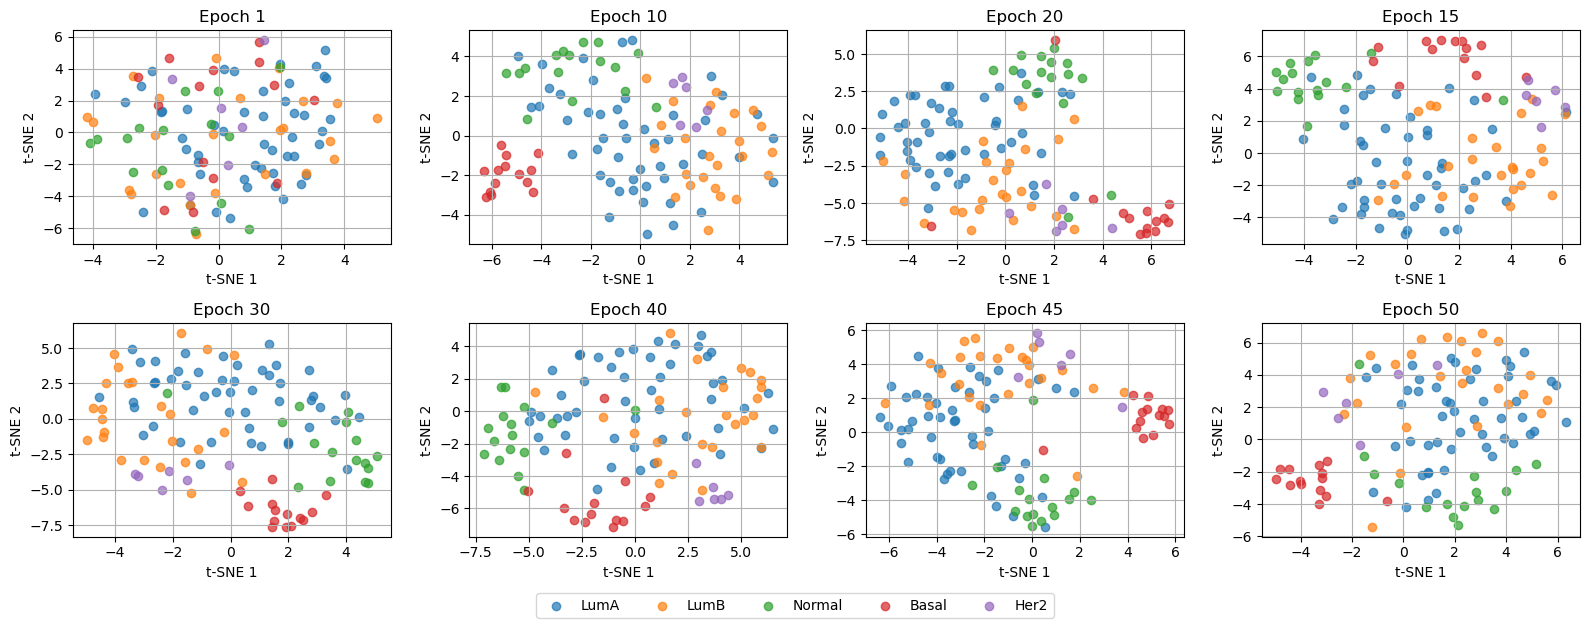

In [210]:
plot_tsne(epochs=[1, 10, 20, 15, 30, 40, 45, 50], cols=4, figsize=(4, 3))

In [100]:
preds, targets = trainer_cb.predict(dataloaders["test"])
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

print(classification_report(targets.numpy(), preds.numpy()))
params = get_training_parameters(trainer_cb)

print(json.dumps(params, indent=4))

✅ Test Accuracy: 0.6970
              precision    recall  f1-score   support

           0       0.74      0.69      0.71        29
           1       0.53      0.60      0.56        15
           2       0.78      0.78      0.78         9
           3       0.80      0.89      0.84         9
           4       0.67      0.50      0.57         4

    accuracy                           0.70        66
   macro avg       0.70      0.69      0.69        66
weighted avg       0.70      0.70      0.70        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "MultiOmicsLoss",
        "beta": 0.25,
        "use_focal": true,
        "focal_gamma": 2.5,
        "label_smoothing": 0,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "Adam",
        "lr": 0.0002,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0
    }
}


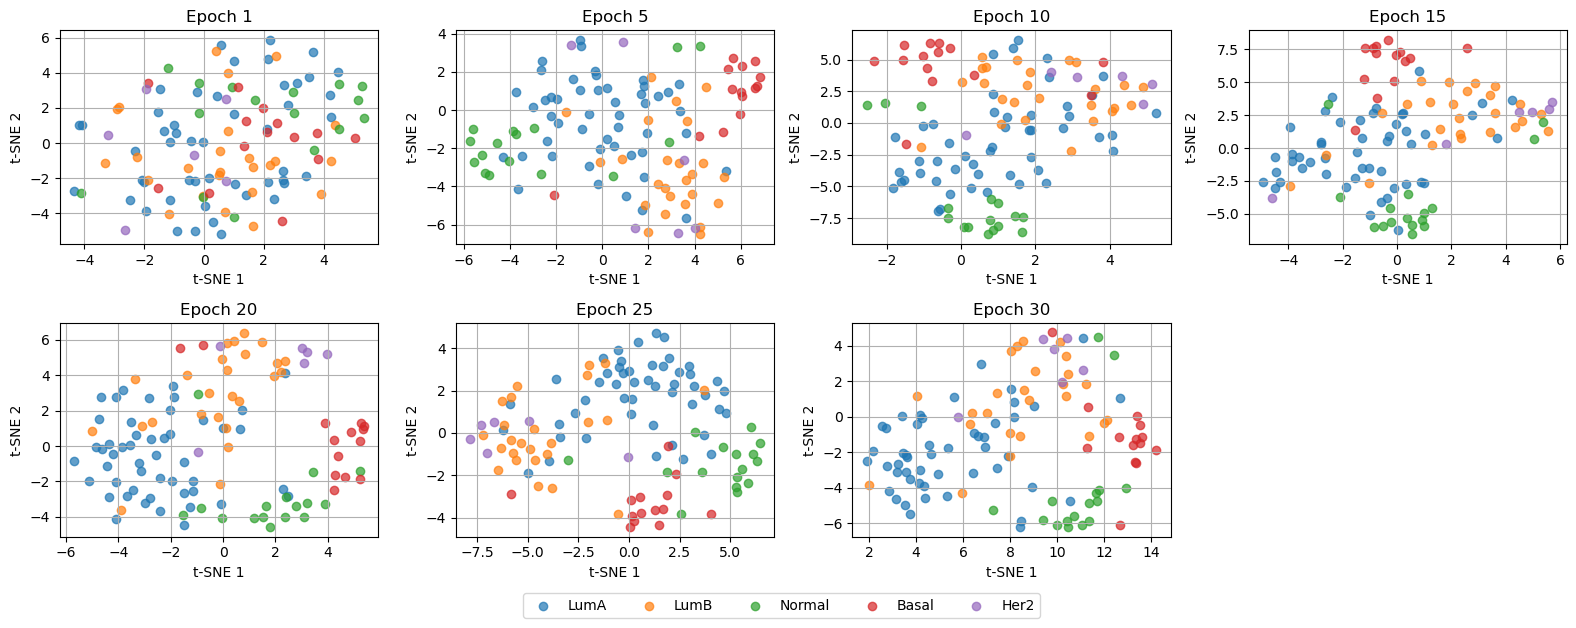

In [103]:


plot_tsne(epochs=[1, 5, 10, 15, 20, 25, 30], cols=4, figsize=(4, 3))

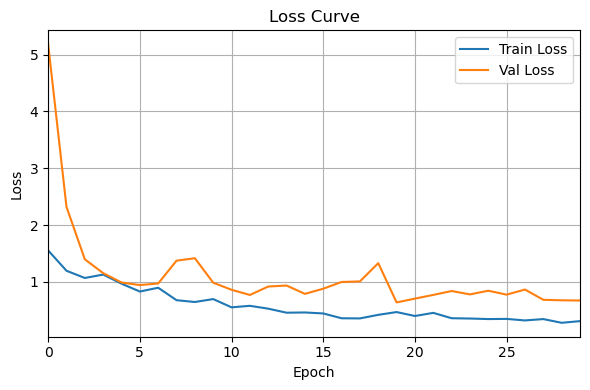

In [104]:
plot_loss(loss_path="logs/loss_history.json", figsize=(6, 4))

In [105]:
preds, targets, logits = trainer_cb.predict(dataloaders["test"], return_logits=True)

In [50]:
import torch.nn.functional as F
probs = F.softmax(logits, dim=1)
predictions = torch.argmax(probs, dim=1)

predictions 

tensor([1, 1, 1, 1, 0, 0, 3, 4, 0, 1, 3, 3, 0, 1, 0, 2, 0, 0, 3, 2, 0, 1, 4, 3,
        0, 0, 0, 1, 1, 3, 1, 2, 3, 1, 1, 0, 3, 0, 1, 0, 1, 3, 2, 1, 0, 0, 2, 0,
        0, 4, 2, 0, 1, 3, 3, 1, 0, 4, 0, 1, 3, 0, 0, 0, 0, 2])

In [84]:



loss_fn = MultiOmicsLoss(
    beta=0.25,               # Target KL weight
    # annealing_steps=5000,   # Total steps to anneal over
    use_focal=True,
    focal_gamma=2.5,
    label_smoothing=0,
    class_weights=torch.tensor([1.0, 1.0, 1.0, 1.5, 2.5], device="cuda") # or torch.tensor([...], device="cuda")
)

mirna_dim = 1046
rna_exp_dim = 13054
methy_shape = (50, 100)  # e.g., (50, 100)
latent_dim = 32
num_classes = 5

# Instantiate model
multiomics_model = MultiOmicsClassifier(
    mirna_dim=mirna_dim,
    rna_exp_dim=rna_exp_dim,
    methy_shape=methy_shape,
    latent_dim=latent_dim,
    num_classes=num_classes
)




loss_callback = LossRecorderCallback(save_path="logs/loss_history.json")
acc_callback = AccuracyRecorderCallback(save_path=Path("logs/accuracy_history.json"))
tsne_callback = TSNERecorderCallback(
    val_loader=dataloaders['val'],  # Your validation DataLoader
    device='cuda',
    save_path="logs/tsne_results.pkl"  # Matches your plot_tsne() default
)
attn_cb = AttentionLoggerCallback(save_path="logs/attention_weights.pkl", modality_names=["methy", "mirna", "rna"])




trainer_cb = CallbackTrainer(
    model=multiomics_model,
    optimizer=torch.optim.AdamW(multiomics_model.parameters(), lr=2e-4, weight_decay=0.0001),
    loss_fn=loss_fn,
    device='cuda', 
    callbacks=[loss_callback, tsne_callback, acc_callback, attn_cb],
    seed=42
)

trainer_cb.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=50)


/home/CBBI/wangh5/_PyCharm/proj_dl/losses/focal.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('weight', torch.tensor(weight) if weight is not None else None)



Epoch 1/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s, loss=1.25]


Train Loss: 1.4743


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.99it/s]

Val Loss:   3.2834


✅ Val Accuracy: 0.5000

Epoch 2/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s, loss=1.01]


step    10 | loss: 1.2391 | ce: 0.9555 | kl: 14.8952 | beta: 0.0190
Train Loss: 1.1737


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.10it/s]

Val Loss:   1.7157


✅ Val Accuracy: 0.5818

Epoch 3/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s, loss=1.21]


Train Loss: 1.1144


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.77it/s]

Val Loss:   1.1850


✅ Val Accuracy: 0.6545

Epoch 4/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.50it/s, loss=1.55]


Train Loss: 1.1013


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.23it/s]

Val Loss:   1.0559


✅ Val Accuracy: 0.6818

Epoch 5/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s, loss=0.914]


step    30 | loss: 0.8841 | ce: 0.6366 | kl: 12.8763 | beta: 0.0192
Train Loss: 0.9220


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.67it/s]

Val Loss:   1.0857


✅ Val Accuracy: 0.6636
🚩 End of epoch 5 — Logging attention

Epoch 6/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s, loss=0.915]


step    40 | loss: 0.9152 | ce: 0.7269 | kl: 9.7504 | beta: 0.0193
Train Loss: 0.8707


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.86it/s]

Val Loss:   1.0098


✅ Val Accuracy: 0.6364

Epoch 7/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s, loss=0.647]


Train Loss: 0.7599


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.08it/s]

Val Loss:   0.8948


✅ Val Accuracy: 0.6636

Epoch 8/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s, loss=0.74]


step    50 | loss: 0.6596 | ce: 0.4223 | kl: 12.2327 | beta: 0.0194
Train Loss: 0.7041


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.44it/s]

Val Loss:   1.0060


✅ Val Accuracy: 0.6182

Epoch 9/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s, loss=0.716]


step    60 | loss: 0.5792 | ce: 0.3649 | kl: 10.9938 | beta: 0.0195
Train Loss: 0.6626


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.49it/s]

Val Loss:   1.0586


✅ Val Accuracy: 0.5182

Epoch 10/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.15it/s, loss=0.468]


Train Loss: 0.5895


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.70it/s]

Val Loss:   0.7710


✅ Val Accuracy: 0.7909
🚩 End of epoch 10 — Logging attention

Epoch 11/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s, loss=0.372]


Train Loss: 0.5379


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.33it/s]

Val Loss:   0.7755


✅ Val Accuracy: 0.7000

Epoch 12/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s, loss=0.435]


step    80 | loss: 0.4862 | ce: 0.2563 | kl: 11.6846 | beta: 0.0197
Train Loss: 0.5057


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.14it/s]

Val Loss:   0.6790


✅ Val Accuracy: 0.6818

Epoch 13/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.18it/s, loss=0.49]


Train Loss: 0.4863


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.30it/s]

Val Loss:   0.6097


✅ Val Accuracy: 0.7364

Epoch 14/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.98it/s, loss=0.732]


Train Loss: 0.5292


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.81it/s]

Val Loss:   0.6528


✅ Val Accuracy: 0.7545

Epoch 15/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s, loss=0.369]


step   100 | loss: 0.4802 | ce: 0.2328 | kl: 12.4624 | beta: 0.0199
Train Loss: 0.4444


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.58it/s]

Val Loss:   0.6196


✅ Val Accuracy: 0.7545
🚩 End of epoch 15 — Logging attention

Epoch 16/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s, loss=0.295]


step   110 | loss: 0.2949 | ce: 0.0766 | kl: 10.9476 | beta: 0.0199
Train Loss: 0.4061


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.11it/s]

Val Loss:   0.6177


✅ Val Accuracy: 0.7545

Epoch 17/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s, loss=0.345]


Train Loss: 0.3750


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.82it/s]

Val Loss:   0.7190


✅ Val Accuracy: 0.6273

Epoch 18/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.05it/s, loss=0.308]


step   120 | loss: 0.4314 | ce: 0.2201 | kl: 10.5486 | beta: 0.0200
Train Loss: 0.3618


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.33it/s]

Val Loss:   0.5161


✅ Val Accuracy: 0.8182

Epoch 19/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s, loss=0.413]


step   130 | loss: 0.4073 | ce: 0.2188 | kl: 9.3635 | beta: 0.0201
Train Loss: 0.3757


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.55it/s]

Val Loss:   0.6994


✅ Val Accuracy: 0.7364

Epoch 20/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s, loss=0.405]


Train Loss: 0.3701


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.52it/s]

Val Loss:   0.7110


✅ Val Accuracy: 0.6182
🚩 End of epoch 20 — Logging attention

Epoch 21/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s, loss=0.506]


Train Loss: 0.3901


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.29it/s]

Val Loss:   0.6650


✅ Val Accuracy: 0.7091

Epoch 22/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s, loss=0.283]


step   150 | loss: 0.3358 | ce: 0.1491 | kl: 9.1940 | beta: 0.0203
Train Loss: 0.3455


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s]

Val Loss:   0.5764


✅ Val Accuracy: 0.7273

Epoch 23/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s, loss=0.43]


Train Loss: 0.3602


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.89it/s]

Val Loss:   0.5830


✅ Val Accuracy: 0.7727

Epoch 24/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s, loss=0.359]


Train Loss: 0.3367


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.90it/s]

Val Loss:   0.5305


✅ Val Accuracy: 0.7909

Epoch 25/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.03it/s, loss=0.524]


step   170 | loss: 0.3188 | ce: 0.1138 | kl: 9.9955 | beta: 0.0205
Train Loss: 0.3535


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.87it/s]

Val Loss:   0.5944


✅ Val Accuracy: 0.7545
🚩 End of epoch 25 — Logging attention

Epoch 26/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s, loss=0.264]


step   180 | loss: 0.2644 | ce: 0.1208 | kl: 6.9731 | beta: 0.0206
Train Loss: 0.3269


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.68it/s]

Val Loss:   0.6749


✅ Val Accuracy: 0.6636

Epoch 27/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s, loss=0.334]


Train Loss: 0.3361


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.29it/s]

Val Loss:   0.6259


✅ Val Accuracy: 0.6545

Epoch 28/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s, loss=0.387]


step   190 | loss: 0.3310 | ce: 0.1104 | kl: 10.6667 | beta: 0.0207
Train Loss: 0.3281


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.15it/s]

Val Loss:   0.9309


✅ Val Accuracy: 0.4818

Epoch 29/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.85it/s, loss=0.493]


step   200 | loss: 0.3985 | ce: 0.1977 | kl: 9.6613 | beta: 0.0208
Train Loss: 0.3442


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.12it/s]

Val Loss:   0.5161


✅ Val Accuracy: 0.7545

Epoch 30/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s, loss=1.49]


Train Loss: 0.5107


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.14it/s]

Val Loss:   0.5440


✅ Val Accuracy: 0.7636
🚩 End of epoch 30 — Logging attention

Epoch 31/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s, loss=0.386]


Train Loss: 0.3258


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.78it/s]

Val Loss:   0.6747


✅ Val Accuracy: 0.6000

Epoch 32/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s, loss=0.399]


step   220 | loss: 0.4203 | ce: 0.2073 | kl: 10.1540 | beta: 0.0210
Train Loss: 0.3453


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.96it/s]

Val Loss:   0.4856


✅ Val Accuracy: 0.7636

Epoch 33/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.12it/s, loss=0.22]


Train Loss: 0.2826


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.52it/s]

Val Loss:   0.5414


✅ Val Accuracy: 0.7273

Epoch 34/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.16it/s, loss=0.273]


Train Loss: 0.2848


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.85it/s]

Val Loss:   0.6074


✅ Val Accuracy: 0.7091

Epoch 35/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.95it/s, loss=0.393]


step   240 | loss: 0.2854 | ce: 0.1193 | kl: 7.8474 | beta: 0.0212
Train Loss: 0.2889


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.92it/s]

Val Loss:   0.6935


✅ Val Accuracy: 0.6818
🚩 End of epoch 35 — Logging attention

Epoch 36/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s, loss=0.204]


step   250 | loss: 0.2041 | ce: 0.0267 | kl: 8.3418 | beta: 0.0213
Train Loss: 0.2342


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.10it/s]

Val Loss:   0.5555


✅ Val Accuracy: 0.7091

Epoch 37/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s, loss=0.266]


Train Loss: 0.2866


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.89it/s]

Val Loss:   0.5457


✅ Val Accuracy: 0.7909

Epoch 38/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s, loss=0.21]


step   260 | loss: 0.3177 | ce: 0.1448 | kl: 8.0928 | beta: 0.0214
Train Loss: 0.2544


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.14it/s]

Val Loss:   0.6614


✅ Val Accuracy: 0.7182

Epoch 39/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s, loss=0.416]


step   270 | loss: 0.3106 | ce: 0.1461 | kl: 7.6665 | beta: 0.0215
Train Loss: 0.2946


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.81it/s]

Val Loss:   0.6599


✅ Val Accuracy: 0.7455

Epoch 40/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s, loss=0.339]


Train Loss: 0.2754


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.16it/s]

Val Loss:   0.5853


✅ Val Accuracy: 0.6818
🚩 End of epoch 40 — Logging attention

Epoch 41/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s, loss=0.587]


Train Loss: 0.3548


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.78it/s]

Val Loss:   0.8089


✅ Val Accuracy: 0.7545

Epoch 42/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s, loss=0.294]


step   290 | loss: 0.2300 | ce: 0.0584 | kl: 7.9249 | beta: 0.0217
Train Loss: 0.3153


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.54it/s]

Val Loss:   1.0341


✅ Val Accuracy: 0.6727

Epoch 43/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s, loss=0.179]


Train Loss: 0.2531


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.64it/s]

Val Loss:   0.8224


✅ Val Accuracy: 0.6727

Epoch 44/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s, loss=0.27]


Train Loss: 0.2646


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.55it/s]

Val Loss:   0.7577


✅ Val Accuracy: 0.7545

Epoch 45/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.09it/s, loss=0.187]


step   310 | loss: 0.2395 | ce: 0.0752 | kl: 7.5179 | beta: 0.0219
Train Loss: 0.2347


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.30it/s]

Val Loss:   0.5722


✅ Val Accuracy: 0.7091
🚩 End of epoch 45 — Logging attention

Epoch 46/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.35it/s, loss=0.251]


step   320 | loss: 0.2507 | ce: 0.0869 | kl: 7.4603 | beta: 0.0220
Train Loss: 0.2302


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.57it/s]

Val Loss:   0.5730


✅ Val Accuracy: 0.7727

Epoch 47/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s, loss=0.587]


Train Loss: 0.3097


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.20it/s]

Val Loss:   0.6179


✅ Val Accuracy: 0.7455

Epoch 48/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.05it/s, loss=0.655]


step   330 | loss: 0.2366 | ce: 0.0654 | kl: 7.7655 | beta: 0.0221
Train Loss: 0.3718


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.95it/s]

Val Loss:   0.7750


✅ Val Accuracy: 0.7000

Epoch 49/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s, loss=0.328]


step   340 | loss: 0.4120 | ce: 0.1496 | kl: 11.8455 | beta: 0.0222
Train Loss: 0.3547


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.04it/s]

Val Loss:   0.6970


✅ Val Accuracy: 0.7909

Epoch 50/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.12it/s, loss=0.521]


Train Loss: 0.3415


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.68it/s]

Val Loss:   0.7437


✅ Val Accuracy: 0.7364
🚩 End of epoch 50 — Logging attention
📦 Saved attention log to: logs/attention_weights.pkl


In [78]:
from utils import set_seed
set_seed(42)
preds, targets = trainer_cb.predict(dataloaders["test"])
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

print(classification_report(targets.numpy(), preds.numpy()))
params = get_training_parameters(trainer_cb)

print(json.dumps(params, indent=4))

Fusion module attn_weights: torch.Size([64, 4, 3, 3])
Fusion module attn_weights: torch.Size([2, 4, 3, 3])
✅ Test Accuracy: 0.6667
              precision    recall  f1-score   support

           0       0.64      0.86      0.74        29
           1       0.33      0.07      0.11        15
           2       0.69      1.00      0.82         9
           3       0.80      0.89      0.84         9
           4       1.00      0.25      0.40         4

    accuracy                           0.67        66
   macro avg       0.69      0.61      0.58        66
weighted avg       0.62      0.67      0.60        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "MultiOmicsLoss",
        "beta": 0.25,
        "use_focal": true,
        "focal_gamma": 2.5,
        "label_smoothing": 0,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "AdamW",
        "lr": 0.0002,
        "betas": [
            0.9,
            0.999
        ],
       

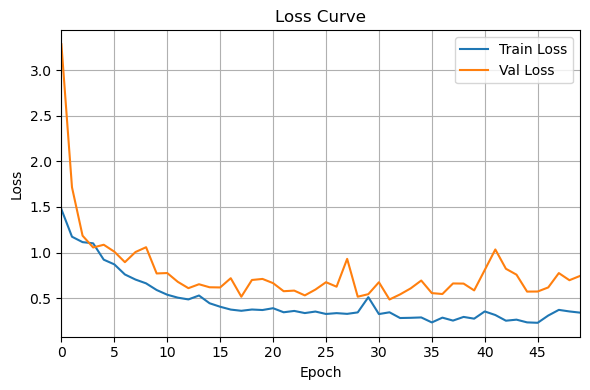

In [79]:
plot_loss(loss_path="logs/loss_history.json", figsize=(6, 4))

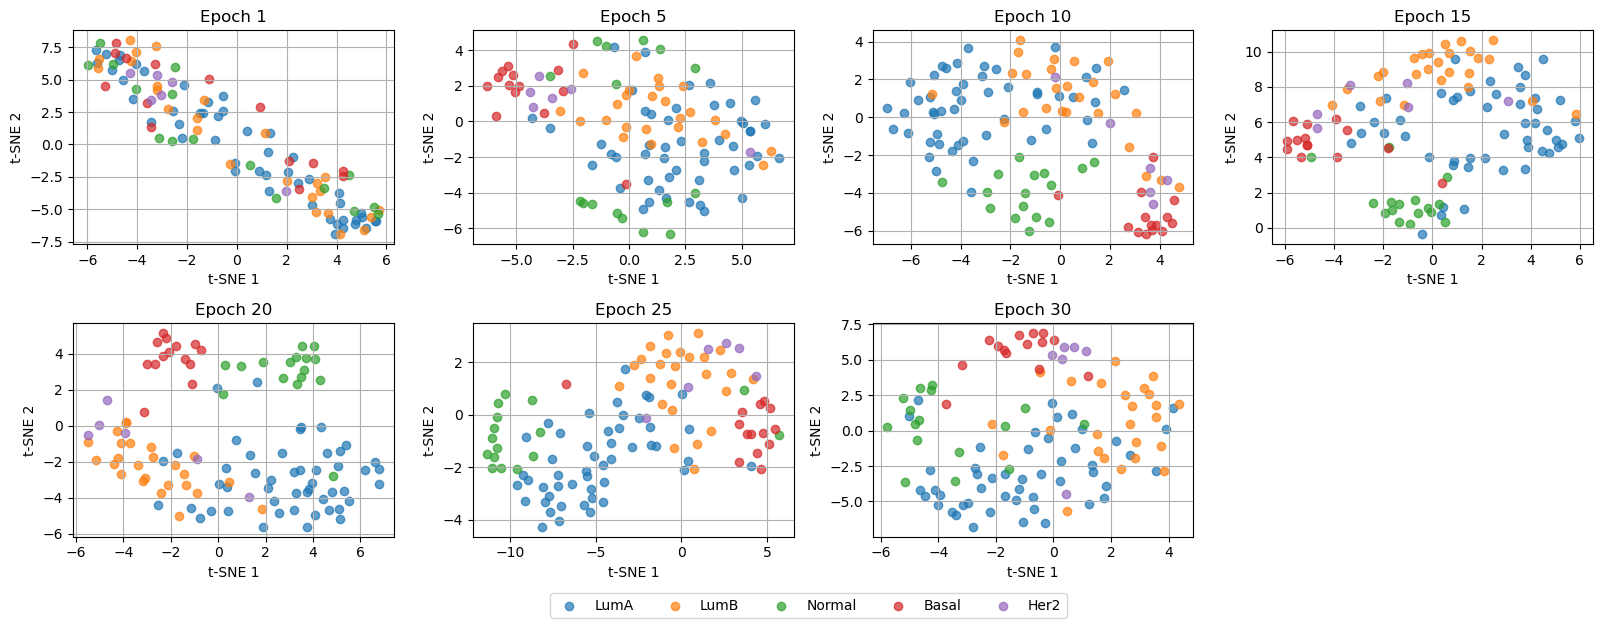

In [80]:
plot_tsne(epochs=[1, 5, 10, 15, 20, 25, 30], cols=4, figsize=(4, 3))

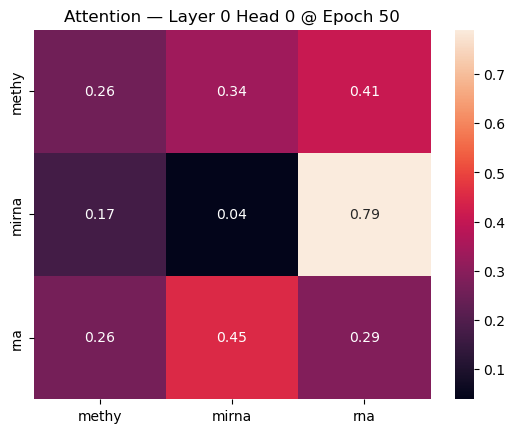

In [83]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

with open("logs/attention_weights.pkl", "rb") as f:
    attention_log = pickle.load(f)

# Example: plot head 0 from layer 0 at epoch 50
last_epoch = attention_log[-1]
weights = last_epoch["attn"][0][0]  # layer 0, head 0

sns.heatmap(weights, annot=True, fmt=".2f", xticklabels=["methy", "mirna", "rna"], yticklabels=["methy", "mirna", "rna"])
plt.title(f"Attention — Layer 0 Head 0 @ Epoch {last_epoch['epoch']}")
plt.show()

